# Intro to Autoencoders

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageOps
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashon MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [3]:
PATH = "./mergedConstellationsEasyStars2Outline_Large/"
checkpoint_path = "./training_ckpt/cp-{epoch:04d}.ckpt"

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = batch_size = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 100

In [5]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

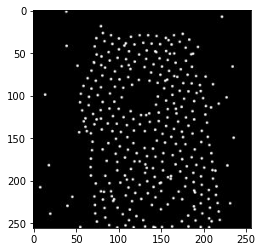

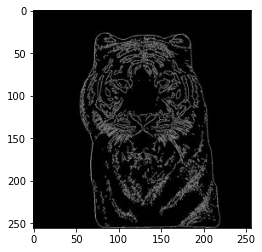

In [6]:
inp, re = load(PATH+'train/object_0_0.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [7]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [8]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [9]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [11]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [12]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

## Input Pipeline

In [13]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [14]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
#Convert to numpy
train_np = np.stack(list(train_dataset))
test_np = np.stack(list(test_dataset))


In [16]:
x_train_noisy = np.squeeze(train_np[:,0,:,:,:])
x_train = np.squeeze(train_np[:,1,:,:,:])

In [17]:
x_test_noisy = np.squeeze(test_np[:,0,:,:,:])
x_test = np.squeeze(test_np[:,1,:,:,:])

## Second example: Image denoising


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

Plot the noisy images.


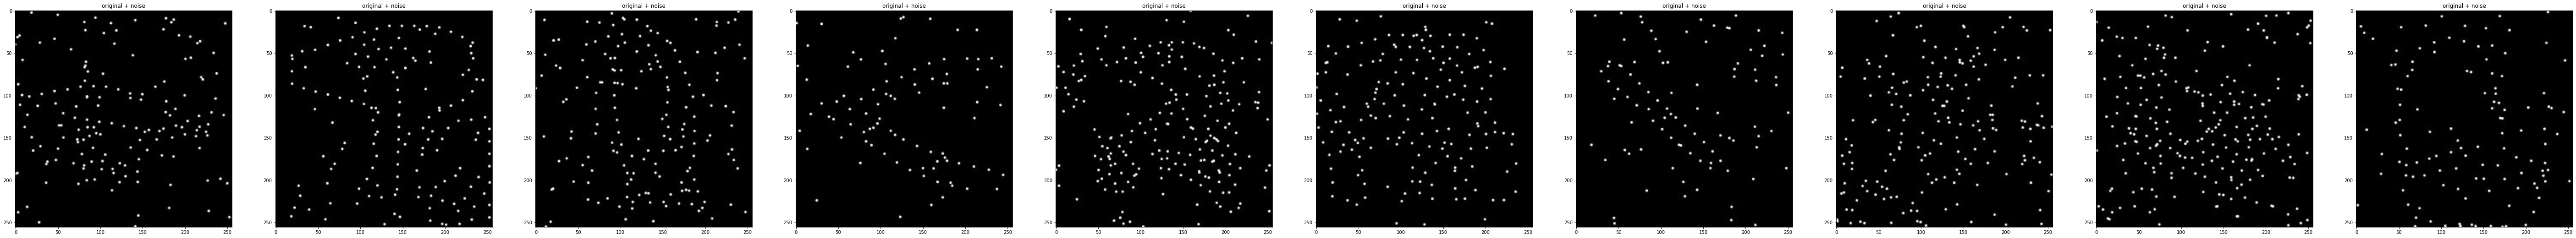

In [18]:
n = 10
plt.figure(figsize=(100, 10))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i])*0.5+0.5)
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [19]:
#Arhitecture from https://learnopencv.com/variational-autoencoder-in-tensorflow/
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(256, 256, 3,)),
      layers.Conv2D(32, kernel_size=3, padding='same', strides=2),
      layers.BatchNormalization(name='bn_1'),
      layers.LeakyReLU(name='lrelu_1'), #Block1
      layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', strides=2),
      layers.BatchNormalization(name='bn_2'),
      layers.LeakyReLU(name='lrelu_2'), #Block2
      layers.Conv2D(64, 3, 2, padding='same', name='conv_3'),
      layers.BatchNormalization(name='bn_3'),
      layers.LeakyReLU(name='lrelu_3'), #Block3
      layers.Conv2D(64, 3, 2, padding='same', name='conv_4'),
      layers.BatchNormalization(name='bn_4'),
      layers.LeakyReLU(name='lrelu_4'), #Block4
      layers.Conv2D(64, 3, 2, padding='same', name='conv_5'),
      layers.BatchNormalization(name='bn_5'),
      layers.LeakyReLU(name='lrelu_5'), #Block5
      layers.Flatten(),
      layers.Dense(200, name='mean')])

    self.decoder = tf.keras.Sequential([
      layers.InputLayer(input_shape=(200,)),
      layers.Dense(4096, name='dense_1'),
      layers.Reshape((8,8,64), name='Reshape'),
      layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1'),
      layers.BatchNormalization(name='bn_1'),
      layers.LeakyReLU(name='lrelu_1'),
      layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2'),
      layers.BatchNormalization(name='bn_2'),
      layers.LeakyReLU(name='lrelu_2'),
      layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3'),
      layers.BatchNormalization(name='bn_3'),
      layers.LeakyReLU(name='lrelu_3'),
      layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4'),
      layers.BatchNormalization(name='bn_4'),
      layers.LeakyReLU(name='lrelu_4'),
      layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



In [39]:
autoencoder = Denoise()

In [40]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=108)


In [41]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [42]:
autoencoder.save_weights(checkpoint_path.format(epoch=0))

In [43]:
#autoencoder.fit(x_train_noisy, x_train,
#                epochs=1,
#                shuffle=True,
#                callbacks=[cp_callback],
#                validation_data=(x_test_noisy, x_test))

In [33]:
#autoencoder.encoder.summary()

In [44]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
Reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 16, 16, 64)        256       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 32, 32, 64)       

Plotting both the noisy images and the denoised images produced by the autoencoder.

## Predict from checkpoint

'./training_ckpt/checkpoint'

In [54]:
tf.keras.models.load_model(checkpoint_dir+"/checkpoint")

OSError: SavedModel file does not exist at: ./training_ckpt/checkpoint/{saved_model.pbtxt|saved_model.pb}

In [50]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
# Load the previously saved weights
autoencoder.load_weights(latest)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x14eb639e5af0> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x14eb639e5910>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x14eb639e5910> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x14eb63940070>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x14eb6396c460> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x14eb639b5310>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x14eb639b5310> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x14eb639a8f40>).

Two checkpoint references resol


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x14eb4470cd00> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x14eb4470ce80>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x14eb4470ce80> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x14eb44766730>).


In [47]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

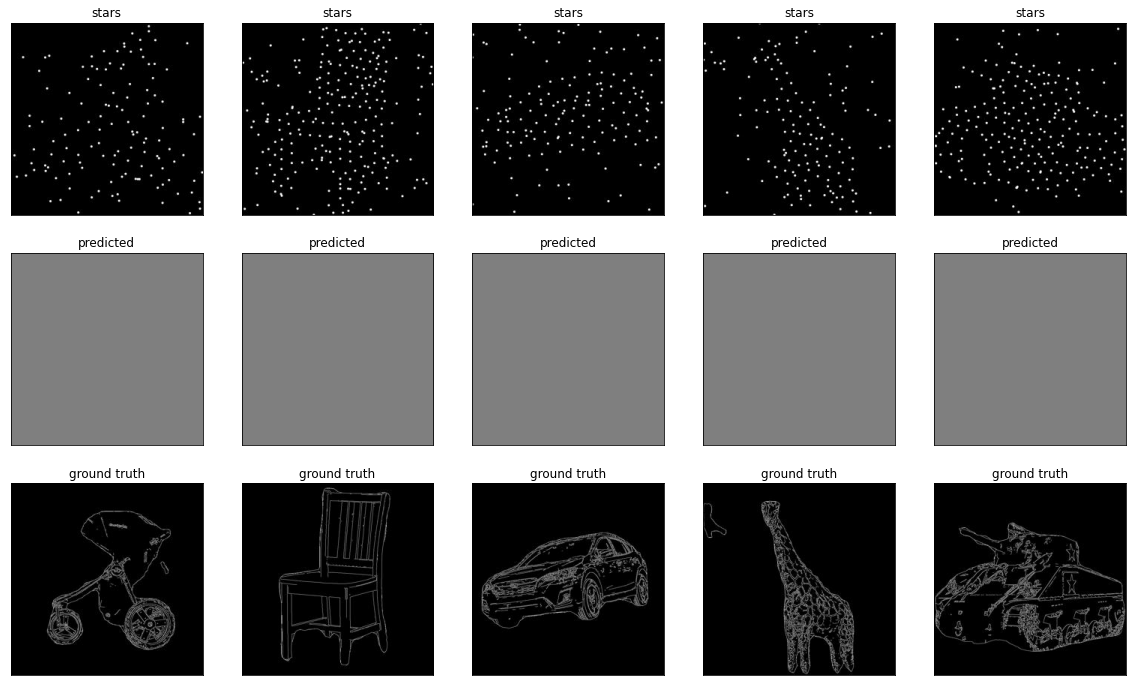

In [28]:
n = 5
plt.figure(figsize=(20, 12))
for i in range(n):

    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("stars")
    plt.imshow(tf.squeeze(x_test_noisy[i])*0.5+0.5)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("predicted")
    plt.imshow(tf.squeeze(decoded_imgs[i])*0.5+0.5)
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("ground truth")
    plt.imshow(tf.squeeze(x_test[i])*0.5+0.5)
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    
plt.show()